# Score-Based Models

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)

## Set-up

In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers -U

In [ ]:
import json
import os
import math
import time
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create directories
from google.colab import drive
drive.mount('/content/drive')

models_dir = "/content/drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

data_dir = "/content/drive/MyDrive/Colab Notebooks/Data"
os.makedirs(data_dir, exist_ok=True)

## Question 1: Training a Light Score-Based Generative Model with Sliced Score Matching on MNIST

**Objective:** Implement and train a lightweight score-based generative model using the sliced score matching technique. The goal is to learn the data distribution's score for generating new samples similar to the training data.

**Dataset:** Use the MNIST dataset, which consists of 70,000 28x28 grayscale images of handwritten digits (0-9). It is divided into 60,000 training images and 10,000 test images. MNIST can be found at https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html To reduce computational complexity, you can downscale the MNIST images to 7x7. Both score models trained with 28x28 and with 7x7 MNIST will get full credits.

**Tasks:**
1. Data preparation: Normalize the MNIST images to have pixel values between -1 and 1.
2. Model Architecture: Construct a simple convolutional neural network (CNN) for estimating the data distribution's score. This network should accept a noisy image as input and output a score estimate.
3. Sliced Score Matching: Implement the sliced score matching objective. Add Gaussian noise to the input images, and train the model to approximate the score of the noise-perturbed data distribution.
4. Training: Use a smaller batch size if necessary to accommodate memory constraints. Train the model using a straightforward optimizer like Adam, with a conservative learning rate (e.g., 1e-3). Consider reducing the number of training epochs and implementing checkpointing to save the model intermittently.
5. Evaluation and Generation: Evaluate the model qualitatively by visual inspection of generated digits.

References:
* https://github.com/mfkasim1/score-based-tutorial/blob/main/01-SGM-without-SDE.ipynb)
* https://towardsdatascience.com/understanding-u-net-61276b10f360
* https://github.com/milesial/Pytorch-UNet
* https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
* https://arxiv.org/pdf/1905.07088.pdf

In [ ]:
# Prepare data
batch_size = 128

# Define a transform to normalize the data and apply basic augmentations
transform = transforms.Compose([
    transforms.Resize((7, 7)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # slight rotation and translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Define model architecture
# (score_network takes input of MNIST image dimension and returns output of
# the same size; score network usually follows the structure of U-Net)

class EncodeLayer(nn.Module):
    """Downsample using 2 layers of 3x3 convolutions, ReLU, and 2x2 max pooling."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.encode_layer(x)


class DecodeLayer(nn.Module):
    """Upsample using 2x2 ConvTranspose2d and 2 layers of 3x3 convolutions with ReLU.
    Forward method concatenates upsampled data with downsampled data corresponding
    to the same layer. See https://github.com/milesial/Pytorch-UNet for details.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.decode_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        height_diff = skip.size()[2] - x.size()[2]
        width_diff = skip.size()[3] - x.size()[3]

        pad = [
            width_diff // 2, width_diff - width_diff // 2, # Pad last dimension (width)
            height_diff // 2, height_diff - height_diff // 2, # Pad second-to-last dimension (height)
        ]
        x = F.pad(x, pad)
        x = torch.cat([x, skip], dim=1)
        return self.decode_layer(x)


class scoreNet28x28(nn.Module):
    """Full version for 28x28 images."""

    def __init__(self, n_channels):
        super().__init__()

        # Encode (downsample)
        self.encode_1 = EncodeLayer(n_channels, 64)
        self.encode_2 = EncodeLayer(64, 128)
        self.encode_3 = EncodeLayer(128, 256)
        self.encode_last = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Decode (upsample)
        self.decode_1 = DecodeLayer(512, 256)
        self.decode_2 = DecodeLayer(256, 128)
        self.decode_3 = DecodeLayer(128, 64)
        self.decode_last = nn.ConvTranspose2d(
            64, n_channels, kernel_size=2, stride=2
        )

    def forward(self, x):
        x1 = self.encode_1(x)
        x2 = self.encode_2(x1)
        x3 = self.encode_3(x2)
        x4 = self.encode_last(x3)
        x5 = self.decode_1(x4, skip=x3)
        x6 = self.decode_2(x5, skip=x2)
        x7 = self.decode_3(x6, skip=x1)
        outputs = self.decode_last(x7)
        return outputs


class scoreNet7x7(nn.Module):
    """Paired-down version for 7x7 images."""

    def __init__(self, n_channels):
        super().__init__()

        # Encode (downsample)
        self.encode_1 = EncodeLayer(n_channels, 64)
        self.encode_2 = EncodeLayer(64, 128)
        self.encode_last = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Decode (upsample)
        self.decode_1 = DecodeLayer(256, 128)
        self.decode_2 = DecodeLayer(128, 64)
        self.decode_last = nn.ConvTranspose2d(
            64, n_channels, kernel_size=5, stride=2, padding=1
        )

    def forward(self, x):
        x1 = self.encode_1(x)
        x2 = self.encode_2(x1)
        x3 = self.encode_last(x2)
        x4 = self.decode_1(x3, skip=x2)
        x5 = self.decode_2(x4, skip=x1)
        outputs = self.decode_last(x5)
        return outputs

In [ ]:
# Implement sliced score matching function
def sample_pv(batch_size: int, channels: int, height: int, width: int) -> np.array:
    """Sample minibatch of projection directions {v1, v2, ..., vn} from pv(v),
    where pv(v) is uniform over all unit directions.
    """
    vectors = torch.randn((batch_size, channels*height*width))
    unit_vectors = vectors / torch.linalg.vector_norm(vectors, ord=2, dim=1, keepdim=True)
    return unit_vectors.reshape(batch_size, channels, height, width)


def calc_loss(model, data):
    """Calculate sliced score matching using the following algorithm:

    For given minibatch of datapoints:
        1. Sample minibatch of projection directions
        2. Estimate sliced score matching loss using empirical mean
    """
    batch_size = data.shape[0]
    model_output = model(data)
    unit_vecs = sample_pv(
        batch_size, data.shape[1], data.shape[2], data.shape[3]
    )
    jvp = torch.autograd.functional.jvp(model, data, unit_vecs)[1].reshape(batch_size, -1)
    total_loss = 0
    for i in range(batch_size):
        vi_T = unit_vecs[i, ...].view(1, -1) # Should have shape (1, 784)
        total_loss = (
            total_loss
            +  torch.matmul(vi_T, jvp[i])
            + (0.5)*torch.square(torch.matmul(vi_T, model_output[i, ...].view(-1)))
        )
    return (total_loss / batch_size)


In [ ]:
# Create model
in_channels = 1
model = scoreNet7x7(in_channels)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# Training
n_epochs = 40
lowest_abs_loss = None

model.train()
t0 = time.time()
for i_epoch in range(n_epochs):
    total_loss = 0
    for data, _ in train_loader:
        opt.zero_grad()

        # training step
        loss = calc_loss(model, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss += loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 1 == 0:
        print(f"Epoch {i_epoch} (time: {round(time.time() - t0, 0)}s): \
                loss: {round(total_loss / len(data), 3)}")

    # save model if improving
    epoch_loss = abs(total_loss / len(data))
    if (lowest_abs_loss is None) or (epoch_loss < lowest_abs_loss):
        lowest_abs_loss = epoch_loss
        torch.save(
            model.state_dict(),
            os.path.join(models_dir, f'FisherScoremodel_epoch{i_epoch}.pt')
        )
        print(f'Saved model for epoch {i_epoch}')

In [ ]:
# Load trained model
load_model_name = "FisherScoremodel_epoch21"
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if torch.cuda.is_available():
    model.load_state_dict(torch.load(load_model_path))
else:
    model.load_state_dict(
        torch.load(load_model_path, map_location=torch.device("cpu"))
    )

In [ ]:
# Sample images from trained score model
def normalize_vec(vec):
    """Normalizes vector to range [-1, 1] to match MNIST images."""
    return 2 * (vec - vec.min()) / (vec.max() - vec.min()) - 1

# Using Unadjusted Langevin Sampling
burn_in = 20000
n_samples = 9
eta = 1e-8

# Get dimensions of image
ex, _ = next(iter(train_loader))
ex = ex[0].unsqueeze(0)
ndim = ex.shape[-1] * ex.shape[-2] # height x width
samples = []

model.eval()
with torch.no_grad():
    for i in range(n_samples):

        current_sample = normalize_vec(torch.randn_like(ex))

        for j in range(burn_in):
            next_sample = (
                current_sample
                - eta * model(current_sample)
                + np.sqrt(2*eta) * torch.randn_like(current_sample)
            )
            current_sample = next_sample

        # save samples
        samples.append(current_sample.view(ndim).detach().numpy())


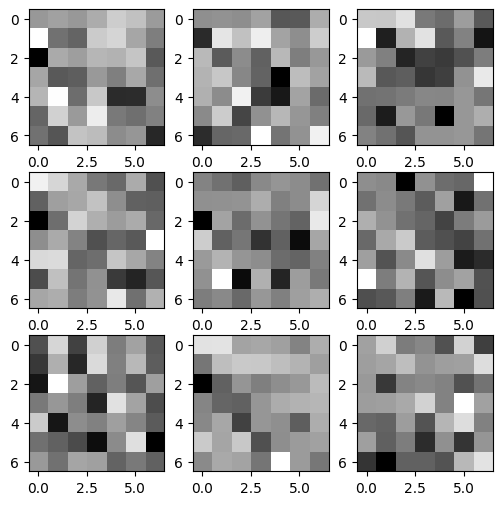

In [ ]:
# Plot generated samples
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(samples[i*3 + j].reshape(7, 7), cmap='gray')

# still looks like random noise...not sure what's going wrong